## Setup

In [1]:
import sys
sys.path.append('../')
del sys
%reload_ext autoreload
%autoreload 2

In [2]:
from modeling.pipeline import Pipeline
from modeling.nn import MLP
from modeling.utils import rank, precision_at_k, recall_at_k, ap_at_k, ndcg

import torch
from numpy import mean, arange
import matplotlib.pyplot as plt

## Display functions

In [3]:
def show_pipeline(pipeline):
    for inputs, targets in pipeline.train_loader[:10]:
        print("\nInputs:")
        for key, item in inputs.items():
            print(key, ':', item)

        print("\nTargets:")
        print(targets)

        if sum(targets) > 0:
            print("Good answers:")
            for i in range(len(targets)):
                if targets[i]:
                    print(inputs['choices'][i])
                    
def show_model(pipeline, model):
    for inputs, targets in pipeline.train_loader[:100]:
        features = model.features(inputs)
        outputs = model.pred(features)
        ranks = rank(outputs)
        score = model.score(ranks, targets, model.k)

        if sum(targets) > 0:
            mask = targets > 0
            grades = outputs[:, 1][mask]
            ranks = ranks[mask]
            print("score: %.3f" % score)
            print("ranks of the true labels:", ranks, ", grades of the true labels:", grades)
            print()
            
def plot_metrics(train_losses, train_scores, valid_losses, valid_scores):
    epoch_number, epoch_length = len(train_losses), len(train_losses[0])

    x1 = arange(0, epoch_number, 1./epoch_length)
    x2 = arange(1, epoch_number + 1)

    flatten_train_losses = [loss for epoch_losses in train_losses for loss in epoch_losses]
    flatten_train_scores = [score for epoch_scores in train_scores for score in epoch_scores]
    flatten_valid_losses = [mean(losses) for losses in valid_losses]
    flatten_valid_scores = [mean(scores) for scores in valid_scores]

    fig, ax1 = plt.subplots(figsize=(15, 5))
    ax1.set_xlabel('epochs')

    color = 'tab:red'
    ax1.set_yscale('log')
    ax1.plot(x1, flatten_train_losses, color=color, label='train loss')
    ax1.set_ylabel('loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    color = 'tab:orange'
    ax1.scatter(x2, flatten_valid_losses, color=color, label='valid loss')

    color = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.plot(x1, flatten_train_scores, color=color, label='score')
    ax2.set_ylabel('score', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    color = 'tab:cyan'
    ax1.scatter(x2, flatten_valid_scores, color=color, label='valid scores')

    fig.legend()

## Data pipeline parameters

In [4]:
batch_size = 64
drop_last = False
test_proportion = 0.25
valid_proportion = 0.25
use_k_fold = False
k_k_fold = None

## Score

In [5]:
score = recall_at_k
k_score = 32
n_updates = 430

## Load the data

In [6]:
pipeline = Pipeline(use_k_fold=use_k_fold)
pipeline.process_data(batch_size=batch_size,
                      drop_last=drop_last,
                      test_proportion=test_proportion,
                      valid_proportion=valid_proportion,
                      k=k_k_fold)

Processing the modeling task...
Computing the annotated queries...
Initial length of queries: 0
Object loaded from ../results/../results/task_annotation/v2_0/task/queries_size10k_shuffle_articles1_queries1_seed0.pkl
Object loaded from ../results/../results/task_annotation/v2_1/task/queries_sizemax_shuffle_articles1_queries1_seed0.pkl
Object loaded from ../results/../results/task_annotation/v2_2/task/queries_sizemax_shuffle_articles1_queries1_seed0.pkl
Final length of queries: 61056
Done (elapsed time: 1s).

Computing the annotations...
Initial length of annotations: 0
Object loaded from ../results/task_annotation/v2_0/results/batch_00_complete.csv
   Correcting "n this article, Nevada and Ohio are discussed. The two American states..." to " The two American states..."
   Correcting "In this article, California and Oregon are discussed. The two neighboring states..." to " The two neighboring states..."
   Correcting "In this article, California and Oregon are discussed. The two West Coa

## Oberseve the data

In [7]:
show_pipeline(pipeline)


Inputs:
entities_type_ : person
entities : ['Michael R. Bloomberg', 'Stanley K. Schlein']
summaries : ['Michael Rubens Bloomberg KBE is an American businessman, politician, author, and philanthropist. As of October 2019, his net worth was estimated at $51.1 billion, making him the 12th richest person in the United States and the 17th richest person in the world. He has joined The Giving Pledge, whereby billionaires pledge to give away at least half of their wealth.', 'No information found.']
context : Bloomberg to Replace Head Of Civil Service Commission: In just the last two years, he helped the Yankees achieve their goal of starting a new stadium in the Bronx, was an election-law adviser to Fernando Ferrer during his unsuccessful challenge to Mr. Bloomberg last year, and represented Bronx politicians in talks over the city 's plans to build a water-filtration plant under Van Cortlandt Park. He was named chairman of the commission by Mayor Bloomberg .
choices : ['former professional 

## Baselines

### Random

In [8]:
from modeling.models import RandomBaseline

model = RandomBaseline(score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=True)

In [9]:
scores = pipeline.evaluate_baseline(model=model, n_updates=n_updates)

Evaluation of the model...




Test Score: 0.004


In [10]:
show_model(pipeline, model)

score: 0.100
ranks of the true labels: tensor([9.]) , grades of the true labels: tensor([0.7252])

score: 0.000
ranks of the true labels: tensor([21.]) , grades of the true labels: tensor([0.3471])

score: 0.100
ranks of the true labels: tensor([2.]) , grades of the true labels: tensor([0.9348])

score: 0.000
ranks of the true labels: tensor([11.]) , grades of the true labels: tensor([0.7059])

score: 0.000
ranks of the true labels: tensor([22.]) , grades of the true labels: tensor([0.3671])

score: 0.000
ranks of the true labels: tensor([11.]) , grades of the true labels: tensor([0.5514])

score: 0.000
ranks of the true labels: tensor([29.]) , grades of the true labels: tensor([0.1259])

score: 0.100
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([0.9887])

score: 0.000
ranks of the true labels: tensor([26.]) , grades of the true labels: tensor([0.2137])

score: 0.000
ranks of the true labels: tensor([29.]) , grades of the true labels: tensor([0.1013])

sco

### Counts

In [11]:
from modeling.models import CountsBaseline

model = CountsBaseline(score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=True)

Learning answers counts...


In [12]:
scores = pipeline.evaluate_baseline(model=model, n_updates=n_updates)

Evaluation of the model...




Test Score: 0.011


In [13]:
show_model(pipeline, model)

score: 0.000
ranks of the true labels: tensor([11.]) , grades of the true labels: tensor([0.0116])

score: 0.100
ranks of the true labels: tensor([2.]) , grades of the true labels: tensor([0.5312])

score: 0.000
ranks of the true labels: tensor([14.]) , grades of the true labels: tensor([0.0500])

score: 0.100
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.100
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.100
ranks of the true labels: tensor([2.]) , grades of the true labels: tensor([0.6000])

score: 0.100
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.100
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.100
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.100
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.000
ranks of the true l

### Summaries Counts

In [14]:
from modeling.models import SummariesCountBaseline

model = SummariesCountBaseline(score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=True)

In [15]:
scores = pipeline.evaluate_baseline(model=model, n_updates=n_updates)

Evaluation of the model...




Test Score: 0.006


In [16]:
show_model(pipeline, model)

score: 0.100
ranks of the true labels: tensor([2.]) , grades of the true labels: tensor([1.])

score: 0.100
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.100
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.000
ranks of the true labels: tensor([30.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([30.]) , grades of the true labels: tensor([0.])

score: 0.100
ranks of the true labels: tensor([10.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([23.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([23.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([18.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([29.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tens

### Summaries Overlap

In [17]:
from modeling.models import SummariesOverlapBaseline

model = SummariesOverlapBaseline(score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=True)

In [18]:
scores = pipeline.evaluate_baseline(model=model, n_updates=n_updates)

Evaluation of the model...




Test Score: 0.006


In [19]:
show_model(pipeline, model)

score: 0.100
ranks of the true labels: tensor([2.]) , grades of the true labels: tensor([1.])

score: 0.100
ranks of the true labels: tensor([9.]) , grades of the true labels: tensor([1.])

score: 0.100
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.000
ranks of the true labels: tensor([30.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([30.]) , grades of the true labels: tensor([0.])

score: 0.100
ranks of the true labels: tensor([10.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([23.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([23.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([18.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([29.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tens

## Models
### Loss

In [8]:
weight = torch.tensor([1, 10], dtype=torch.float)
loss = torch.nn.CrossEntropyLoss(weight=weight)

## Parameters

In [14]:
n_updates = 430
n_epochs = 1

### BOW

In [10]:
from modeling.models import BOWModel

model = BOWModel(min_vocab_frequency=100, net=None, optimizer=None, loss=loss, score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=False)

NameError: name 'score' is not defined

In [23]:
model.net = MLP(input_dim=5538,
                hidden_dim=500,
                output_dim=2,
                dropout=0.1)
model.optimizer = torch.optim.Adam(model.net.parameters(),
                                   lr=1e-5)

In [24]:
train_losses, train_scores, valid_losses, valid_scores = pipeline.train_model(model=model, 
                                                                              n_epochs=n_epochs, 
                                                                              n_updates=n_updates)

Training of the model...




Epoch 1/1: Validation Loss: 0.604 Validation Score: 0.093
--------------------------------------------------------------


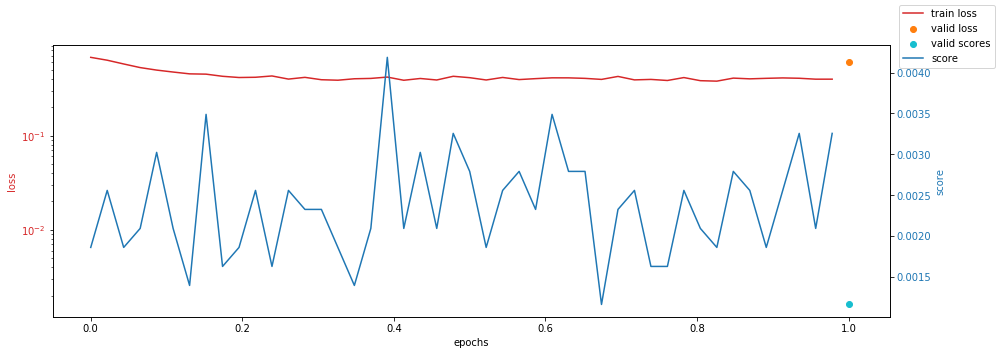

In [30]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)

### Embedding

In [15]:
from modeling.models import EmbeddingModel

model = EmbeddingModel(net=None, optimizer=None, loss=loss, score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=False)

Initializing the Word2Vec embedding...
Input dimension: 600


In [16]:
model.net = MLP(input_dim=600,
                hidden_dim=200,
                output_dim=2,
                dropout=0.1)
model.optimizer = torch.optim.Adam(model.net.parameters(),
                                   lr=1e-6)

In [ ]:
train_losses, train_scores, valid_losses, valid_scores = pipeline.train_model(model=model, 
                                                                              n_epochs=n_epochs, 
                                                                              n_updates=n_updates)

Training of the model...



In [ ]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)